![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Análisis de sentimientos y técnicas de NLP

En este taller podrán poner en práctica sus conocimientos sobre las diferentes técnicas para el procesamiento de lenguaje natural. El taller está constituido por 5 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción sentimientos de viajeros en Twitter

En este taller se usará el conjunto de datos de sentimientos sobre distintas aerolíneas de EE.UU. provenientes de Twitter. Cada observación contiene si el sentimiento de los tweets es positivo, neutral o negativo teniendo en cuenta distintas variables como aerolínea y las razones de los sentimientos negativos (como "retraso en el vuelo" o "servicio grosero"). El objetivo es predecir el sentimiento asociado a cada tweet. Para más detalles pueden visitar el siguiente enlace: [datos](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Lectura de la información de archivo .zip
tweets = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/Tweets.zip', index_col=0)

# Visualización dataset
tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# Impresión tamaño del cojunto de datos
tweets.shape

(14640, 14)

### Análisis descriptivo

In [ ]:
# Cuenta de tweets por cada sentimiento
tweets['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [ ]:
# Cuenta de tweets por cada aerolínea
tweets['airline'].value_counts()

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: count, dtype: int64

<Axes: title={'center': 'Sentiminetos por aerolínea'}, xlabel='airline'>

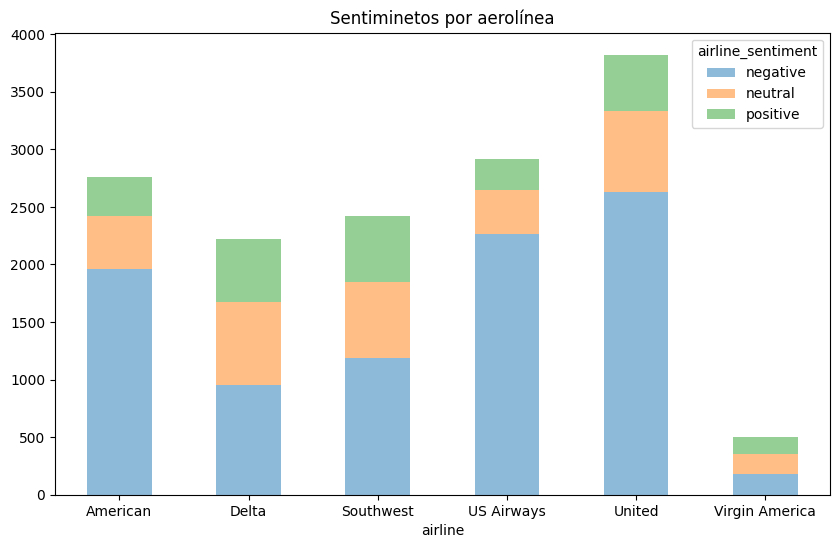

In [ ]:
# Plot con cuenta de tweets por cada aerolínea y sentimiento
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiminetos por aerolínea")

In [ ]:
# Cuenta de tweets por tweet_location
tweets['tweet_location'].value_counts()

tweet_location
Boston, MA              157
New York, NY            156
Washington, DC          150
New York                127
USA                     126
                       ... 
Seattle (duh!)            1
South ~O-H-I-O~ Side      1
Pocono Raceway            1
denver, co                1
Nigeria,lagos             1
Name: count, Length: 3081, dtype: int64

In [ ]:
# Cuenta de location
tweets['tweet_location'].nunique()

3081

In [ ]:
# Cuenta de tweets por negativereason
tweets['negativereason'].value_counts()

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: count, dtype: int64

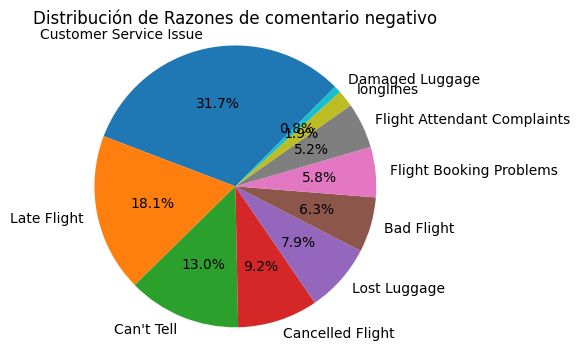

In [ ]:
#  gráfico de pastel por negativereason
razones = tweets["negativereason"].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(razones, labels=razones.index, autopct='%1.1f%%', startangle=45)
plt.title('Distribución de Razones de comentario negativo')  # Título del gráfico
plt.axis('equal')  # Eso hace que el gráfico sea un círculo perfecto
plt.show()

### Liberias y Variables de interés y predicción

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [ ]:
# Separación de variables predictoras (X) y de variable de interés (y)
X = tweets['text']
y = tweets['airline_sentiment'].map({'negative':-1,'neutral':0,'positive':1})

In [ ]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Uso de CountVectorizer

En la celda 1 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 1
# Crear el vectorizador CountVectorizer
vectorizer = CountVectorizer()

In [ ]:
# Aplicar CountVectorizer a los datos de entrenamiento y test
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [ ]:
# Crear y entrenar el modelo de random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de clasificación
clf = RandomForestClassifier()
clf

RandomForestClassifier()

In [ ]:
clf.fit(X_train_count, y_train)

RandomForestClassifier()

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test_count)
accuracy_CountVectorizer = accuracy_score(y_test, y_pred)
print("Accuracy del modelo:", accuracy_CountVectorizer)

Accuracy del modelo: 0.7769039735099338


El modelo de RF utilizando CountVectorizer clasificó correctamente el sentimiento de alrededor de 77% de los tweets.

### Punto 2 - Eliminación de Stopwords

En la celda 2 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **eliminen stopwords** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 2
# Definición de función que recibe un texto vectorizado y calcula el acurracy de un modelo random fores

def tokenize_test(vect, X_train, X_test, y_train, y_test):
    # Vectorización del texto
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    # Crear y entrenar el modelo Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_dtm, y_train)
    y_pred = rf.predict(X_test_dtm)

    accuracy = accuracy_score(y_test, y_pred)
    return(accuracy)


In [ ]:
# Eliminación de stopwords al usar el parámetro 'stop_words' de la función CountVectorizer()
vect_no_stopw = CountVectorizer(stop_words='english')

In [ ]:
# Desempeño del modelo sin considerar stopwords
tokenize_test_stopwords=tokenize_test(vect_no_stopw, X_train, X_test, y_train, y_test)
print(tokenize_test_stopwords)

0.761796357615894


Se eliminaron las "stopwords" del texto, con el fin de limpiar y mejorar su calidad. El número de features generado posterior a correr el modelo de RF con el vectorizador fue 11777 y el accuracy disminuyó muy levemente a 76.17%. La eliminación de las stopwords puede haber afectado negativamente, puesto que se pudo haber perdido información o palabras relevantes.

### Punto 3 - Lematización con verbos

En la celda 3 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función CountVectorizer, **lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 3
# Importación de librerias
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
vect = CountVectorizer()
vect.fit(X_train)

CountVectorizer()

In [ ]:
# Definiicón de lista con vocabulario de la matriz de documentos
words = list(vect.vocabulary_.keys())[:100]

In [ ]:
# Obtención e impresión de los lemas de cada palabra de la lista asumiendo que cada palabra es un sustantivo
print([wordnet_lemmatizer.lemmatize(word) for word in words])

['jetblue', 'of', 'course', 'am', 'americanair', 'complt', 'incompetence', 'on', 'flt', '295', 'lav', 'delay', 'from', 'pln', 'that', 'lnded', 'last', 'nite', 'no', 'internet', 'and', 'poor', 'svc', 'not', 'what', 'expect', 'southwestair', 'flight', '4968', 'n8325d', 'departs', 'mco', 'enroute', 'to', 'no_airport', 'http', 'co', 'fd4snvkiem', 'usairways', 'doe', 'anyone', 'your', 'airline', 'know', 'how', 'do', 'their', 'job', 'united', 'want', 'plane', 'dad', 'my', '386', 'dallas', 'jacksonville', 'fl', 'ha', 'been', 'cancelled', 'flightled', 'one', 'notified', 'me', 'going', 'it', 'is', 'trying', 'make', 'but', 'probably', 'too', 'late', 'did', 'see', 'an', 'email', 'could', 'call', 'pittsburgh', 'international', 'always', 'look', 'forward', 'jb', 'rt', 'bostongarden', 'looking', 'welcoming', 'you', 'onboard', 'have', 'the', 'ability', 'switch', 'cannot', 'tell', 'where', 'bag', 'are']


In [ ]:
# Obtención e impresión de los lemas de cada palabra de la lista asumiendo que cada palabra es un verbo
print([wordnet_lemmatizer.lemmatize(word,pos='v') for word in words])

['jetblue', 'of', 'course', 'be', 'americanair', 'complt', 'incompetence', 'on', 'flt', '295', 'lav', 'delay', 'from', 'pln', 'that', 'lnded', 'last', 'nite', 'no', 'internet', 'and', 'poor', 'svc', 'not', 'what', 'expect', 'southwestair', 'flight', '4968', 'n8325d', 'depart', 'mco', 'enroute', 'to', 'no_airport', 'http', 'co', 'fd4snvkiem', 'usairways', 'do', 'anyone', 'your', 'airline', 'know', 'how', 'do', 'their', 'job', 'unite', 'want', 'plane', 'dad', 'my', '386', 'dallas', 'jacksonville', 'fl', 'have', 'be', 'cancel', 'flightled', 'one', 'notify', 'me', 'go', 'it', 'be', 'try', 'make', 'but', 'probably', 'too', 'late', 'do', 'see', 'an', 'email', 'could', 'call', 'pittsburgh', 'international', 'always', 'look', 'forward', 'jb', 'rt', 'bostongarden', 'look', 'welcome', 'you', 'onboard', 'have', 'the', 'ability', 'switch', 'cannot', 'tell', 'where', 'bag', 'be']


In [ ]:
# Definición de la función que tenga como parámetro texto y devuelva una lista de lemas
def split_into_lemmas(text):
    text = text.lower()
    words = text.split()
    return [wordnet_lemmatizer.lemmatize(word) for word in words]

In [ ]:
# Creación de matrices de documentos usando CountVectorizer, usando el parámetro 'split_into_lemmas'
vect_lemas = CountVectorizer(analyzer=split_into_lemmas)

In [ ]:
# Desempeño del modelo al lematizar el texto
tokenize_test_lematizen=tokenize_test(vect_lemas,X_train, X_test, y_train, y_test)
print(tokenize_test_lematizen)

0.7555877483443708


El rendimiento del modelo nuevamente disminuye ligeramente, a un accuracy de 75.55%. En este caso, la lematización está asumiendo que cada palabra es un verbo, lo cual puede continuar omitiendo información importante para la identificación de los sentimientos. Adicionalmente, no se está teniendo en cuenta que los tweets pueden contener lenguaje informal, abreviaturas y errores ortográficos, slangs, entre otros. Por último, vemos que el número de features aumenta a 20.084 tras el proceso de lematización, lo que podría sugerir una mayor dispersión de los datos.

### Punto 4 - Multiples técnicas

En la celda 4 creen un modelo de random forest con la libreria sklearn que prediga el sentimiento de los tweets usando los set de entrenamiento y test definidos anteriormente. Usen la función **CountVectorizer, eliminen stopwords, lematizen el texto con verbos** y presenten el desempeño del modelo con la métrica del acurracy.

Recuerden que el preprocesamiento que se haga sobre los datos de entrenamiento  (*.fit_transform()*) deben ser aplicado al set de test (*.transform()*).

In [ ]:
# Celda 4
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
wordnet_lemmatizer = WordNetLemmatizer()


In [ ]:
def split_into_lemmas(text):
    # Lematizador
    wordnet_lemmatizer = WordNetLemmatizer()
    # Conversión del texto a minúsculas y división en palabras
    words = text.lower().split()
    # Lematización, retorna como lista
    return [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

In [ ]:
# CountVectorizer con lematización y eliminación de stopwords
vect_combined = CountVectorizer(analyzer=split_into_lemmas, stop_words='english')

In [ ]:
# Función
def tokenize_test(vect, X_train, X_test, y_train, y_test):

    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)
    # Features lematizadas en el conjunto de train
    # Modelo RF
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_dtm, y_train)
    # Predicción del sentimiento en el conjunto de test
    y_pred = rf.predict(X_test_dtm)
    # Accuracy del modelo
    accuracy = accuracy_score(y_test, y_pred)
    return(accuracy)



0.7595198675496688

In [ ]:
tokenize_test_all=tokenize_test(vect_combined, X_train, X_test, y_train, y_test)
print(tokenize_test_all)

El modelo produjo 19380 features de palabras lematizadas y clasificó correctamente el sentimiento de los usuarios de la aereolinea en un 75.95% de los tweets.

### Punto 5 - Comparación y análisis de resultados

En la celda 5 comparen los resultados obtenidos de los diferentes modelos (random forest) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

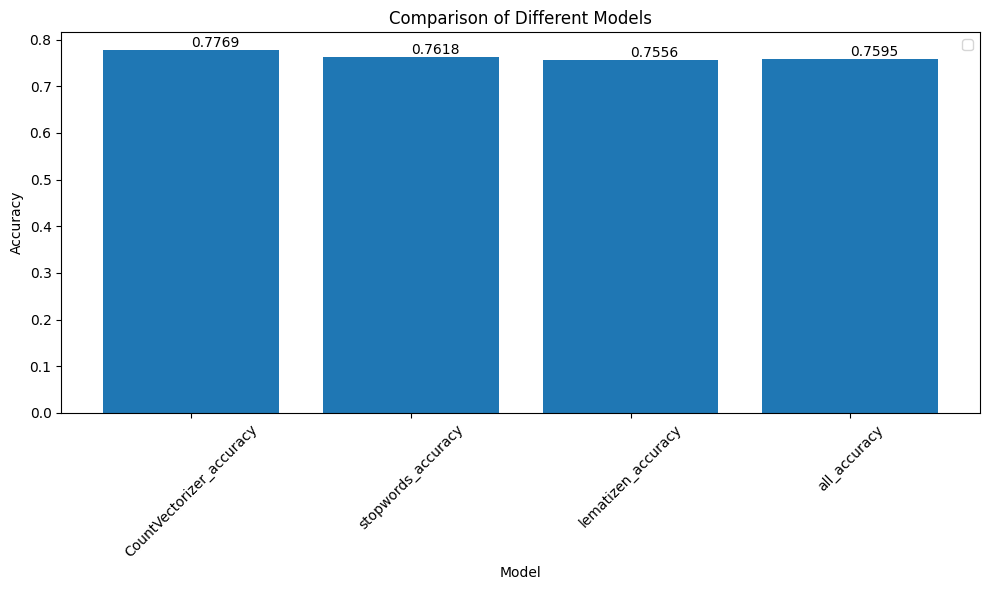

In [ ]:
# Celda 5

results = {
    "CountVectorizer_accuracy": accuracy_CountVectorizer,
    "stopwords_accuracy": tokenize_test_stopwords,
    "lematizen_accuracy": tokenize_test_lematizen,
    "all_accuracy": tokenize_test_all
}


fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(results.keys(), results.values())

for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', va='bottom')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_title('Comparison of Different Models')
plt.xticks(rotation=45)

plt.legend()

plt.tight_layout()
plt.show()

Resultados:

-	**Modelo de RF con CountVectorizer**

•	Features: 11777

•	Accuracy: 0.7700745033112583

-	**Modelo de RF con CountVectorizer + Stopwords**

•	Features: 11777

•	Accuracy: 0.761796357615894

-	**Modelo de RF con CountVectorizer + Lematización**

•	Features: 20084

•	Accuracy: 0.7555877483443708

-	**Modelo de RF con CountVectorizer + Stopwords + Lematización**

•	Features: 19380

•	Accuracy: 0.7595198675496688

El accuracy de todos los otros modelos solo son ligeramente inferiores al modelo con únicamente CountVectorizer. Agregar lematización al modelo no hizo que este mejorara en cuanto a rendimiento, puesto que la accuracy disminuyó, sin embargo, si agregó features. Para la eliminación de Stopwords no hubo adición de features, pero el accuracy también disminuyó levemente. Por su parte, la combinación de CountVectorizer, eliminación de Stopwords y Lematización tuvo un menor número de features que Countvectorizer + lematización y una accuracy un poco mayor que el mismo.

La adición de técnicas como la eliminación de stopwords y la lematización no mejoran la precisión del modelo, lo cual puede indicar que estas técnicas no son tan efectivas para esta base de datos (de tweets), o que la información eliminada puede ser relevante para la clasificación de sentimientos.

**VENTAJAS DEL MEJOR MODELO:**


El modelo que utiliza solo CountVectorizer tiene el mayor porcentaje de accuracy entre todos los modelos anteriores, por lo que es el que tiene la mejor capacidad de clasificación de sentimientos de los tweets. Con 77% de accuracy aproximadamente, tiene el mejor desempeño en términos de precisión frente a los otros. Adicionalmente, tiene el menor número de features (al igual que el modelo con CountVectorizer + Stopwords).


**DESVENTAJAS DEL PEOR MODELO:**

El modelo con menor desempeño es el Modelo de RF con CountVectorizer + Lematización. A pesar del proceso de Lematización, la precisión de este modelo no mejora. Adicionalmente, el número de features aumenta y es mayor al resto de modelos, lo cual puede estar generando ruido.